In [133]:
import numpy as np
import os
from os.path import join, isdir
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib notebook

# Load and proprocess documents
**Load document labels**

In [134]:
segmented_path = u'./corpus/segmented-docs' # it will listdir into unicode
doc_labels = [fn for fn in os.listdir(segmented_path) if isdir(join(segmented_path, fn))] # list only folders
doc_labels_idx = {}
for i, label in enumerate(doc_labels):
    print i, label
    doc_labels_idx[label] = i

0 บริหารธุรกิจ
1 ประมง
2 มนุษยศาสตร์
3 วนศาสตร์
4 วิทยาศาสตร์
5 วิทยาศาสตร์การกีฬา
6 วิศวกรรมศาสตร์
7 วิศวกรรมศาสตร์ กำแพงแสน
8 ศิลปศาสตร์และวิทยาศาสตร์
9 ศึกษาศาสตร์
10 สถาปัตยกรรมศาสตร์
11 สังคมศาสตร์
12 สัตวแพทยศาสตร์
13 สิ่งแวดล้อม
14 อุตสาหกรรมเกษตร
15 เกษตร
16 เกษตร กำแพงแสน
17 เศรษฐศาสตร์
18 เศรษฐศาสตร์ ศรีราชา
19 โครงการสหวิทยาการระดับบัณฑิตศึกษา


** Load dataset **

In [135]:
%%time
dataset_contents, dataset_labels = [], []
for i, label in enumerate(doc_labels):
    curr_dir = join(segmented_path, label)
    fns = os.listdir(curr_dir)
    for fn in fns:
        file_path = join(curr_dir, fn)
        with open(file_path, 'r') as f:
            content = unicode(f.read(), 'utf8')
            dataset_contents.append(content)
            dataset_labels.append(i)
N = len(dataset_contents)
print 'Total Segmented Documents:', N

Total Segmented Documents: 775
Wall time: 12.6 s


** Define a function that trims words and replace all PIPELINE by space **

In [136]:
def pretty_trim(text):
    words = text.split('|')
    stripped_words_generator = (word.strip() for word in words) # generates a stripped word when its next() method is called
    trimmed_words = [word for word in stripped_words_generator if word] # retains words that are not empty
    return ' '.join(trimmed_words)

**Show sample content**

In [137]:
print 'Content:', dataset_contents[1][:2**8], '...'
print 'Label:', dataset_labels[1]

Content: I|50731470|I|0|b| |บท|ที่| |1|I|1|b| |ความ|สาคัญ|ของ|ปัญหา|P|จาก|วิกฤต|เศรษฐกิจ|ใน|ปี| |2550| |ประเทศสหรัฐอเมริกา|ได้|ประสบปัญหา|วิกฤต|เศรษฐกิจ|ที่|มี|P|จุด|กา|เนิด|จาก|หนี้เสีย|ของ|สินเชื่อ|บ้าน|ที่|ปล่อย|กู้|แก่|ผู้|มี|เครดิต|ต่ำกว่า|มาตรฐาน|และ|เกิด|ปัญ ...
Label: 0


** Show sample content after pretty_trimmed() **

In [138]:
print 'Content:', pretty_trim(dataset_contents[1][:2**8]), '...'
print 'Label Str:', doc_labels[dataset_labels[1]]

Content: I 50731470 I 0 b บท ที่ 1 I 1 b ความ สาคัญ ของ ปัญหา P จาก วิกฤต เศรษฐกิจ ใน ปี 2550 ประเทศสหรัฐอเมริกา ได้ ประสบปัญหา วิกฤต เศรษฐกิจ ที่ มี P จุด กา เนิด จาก หนี้เสีย ของ สินเชื่อ บ้าน ที่ ปล่อย กู้ แก่ ผู้ มี เครดิต ต่ำกว่า มาตรฐาน และ เกิด ปัญ ...
Label Str: บริหารธุรกิจ


** Trim all documents **

In [139]:
%%time
dataset_contents_trimmed = [pretty_trim(content) for content in dataset_contents]

Wall time: 12.2 s


** Count number of words for each document **

In [142]:
%time dataset_words_count = np.array([len(content.split()) for content in dataset_contents_trimmed])
print 'Words Count Mean: ', np.mean(dataset_words_count)
dataset_words_count[:min(40,N)]

Wall time: 3.34 s
Words Count Mean:  40804.4154839


array([ 41235,  24706,  41920,  39107,  43159,  53636,  32753,  46280,
        36777,  48854,  33029,  31878,  51160,  63060,  31636,  63538,
        16844,  17461,  33434,  30484,  19858,  92392,  51363,  55388,
        26136,  46479, 196975,  36790,  58717,  67169,  49065,  20123,
        20198,  39262,  42075,  31650,  24313,  17898,  26907,  22453])

** Show words count histogram **

<IPython.core.display.Javascript object>


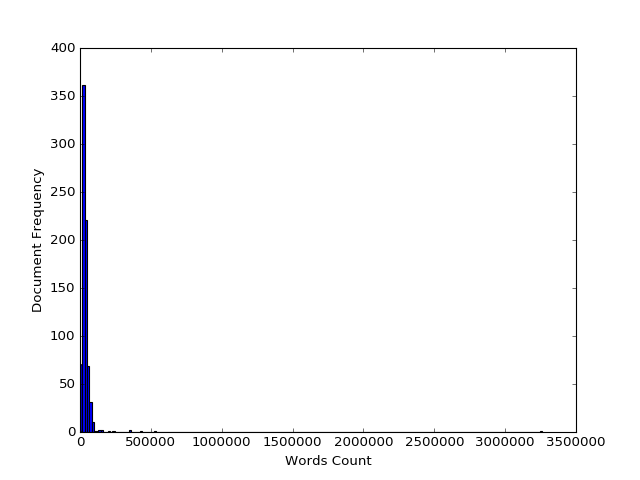

In [147]:
plt.figure()
plt.hist(dataset_words_count, bins=200)
plt.xlabel('Words Count')
plt.ylabel('Document Frequency')
plt.show()

# Machine Learning section

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

## Bag of Words Representation
Initialize a vectorizer that counts word instances and apply Tfidf (Term-Frequency Inverse-Document-Frequency) to them

In [149]:
%%time
tfidf = TfidfVectorizer(encoding=u'utf-8', stop_words='english', binary=False, max_features=None)
dataset_contents_vectorized = tfidf.fit_transform(dataset_contents_trimmed)

Wall time: 42.9 s


** Save extracted feature names to disk **

In [150]:
%%time
fn = 'feature_names.txt'
with open(fn, 'w') as f:
    f.write(u'\n'.join(feature_names).encode('utf8'))
print 'Check file %s to see all extracted feature names' % fn

Check file feature_names.txt to see all extracted feature names
Wall time: 26 ms


**Vectorized Dataset Statistics**

In [151]:
feature_names = tfidf.get_feature_names()
print 'Shape:', dataset_contents_vectorized.shape
print 'Sample content of type %s:' % type(dataset_contents_vectorized)
print dataset_contents_vectorized

Shape: (775, 549944)
Sample content of type <class 'scipy.sparse.csr.csr_matrix'>:
  (0, 530937)	0.000623801002406
  (0, 314220)	0.000337467610818
  (0, 531423)	0.000240220127087
  (0, 531592)	0.000220923013348
  (0, 541523)	0.000231697718509
  (0, 542952)	0.000755112459246
  (0, 534047)	0.000426961498476
  (0, 539131)	0.000655849062227
  (0, 534519)	0.00055742611204
  (0, 534670)	0.00055742611204
  (0, 156958)	0.000467263127512
  (0, 535377)	0.00026401104781
  (0, 536609)	0.000445349981253
  (0, 253630)	0.00126425943365
  (0, 376859)	0.00126425943365
  (0, 376597)	0.00126425943365
  (0, 376594)	0.00126425943365
  (0, 376586)	0.00126425943365
  (0, 376585)	0.00126425943365
  (0, 376583)	0.00126425943365
  (0, 376581)	0.00126425943365
  (0, 124599)	0.00106472921034
  (0, 143536)	0.000938839655719
  (0, 376574)	0.00126425943365
  (0, 376528)	0.00126425943365
  :	:
  (774, 535908)	0.000698762664126
  (774, 549152)	0.000402833192922
  (774, 539320)	0.00167077609811
  (774, 538275)	0.002339

## Dimensionality Reduction

Truncated SVD (Single Value Decomposition) is called Latent Semantic Analysis (LSA) in text analysis context

In [152]:
%%time
svd = TruncatedSVD(n_components=100) # works on sparse data
dataset_contents_reduced = svd.fit_transform(dataset_contents_vectorized)
print 'Shape:', dataset_contents_reduced.shape
print 'Explained Variance Ratio Sum:', svd.explained_variance_ratio_.sum()
print 'Top 5 Explained Variance Ratio:', svd.explained_variance_ratio_[:5]

Shape: (775L, 100L)
Explained Variance Ratio Sum: 0.436515267056
Top 5 Explained Variance Ratio: [ 0.07590819  0.0251947   0.01507222  0.00945961  0.00957984]
Wall time: 30.9 s


## Training models

In [165]:
%%time
models = [LogisticRegression(), MultinomialNB(), LinearSVC(), DecisionTreeClassifier(max_depth=100),
          SGDClassifier(), KNeighborsClassifier(n_neighbors=2), Perceptron(), RandomForestClassifier()]
for clf in models:
    print 'Training', type(clf).__name__
    %time clf.fit(dataset_contents_vectorized, dataset_labels)

Training LogisticRegression
Wall time: 22.1 s
Training MultinomialNB
Wall time: 805 ms
Training LinearSVC
Wall time: 7.68 s
Training DecisionTreeClassifier
Wall time: 11.4 s
Training SGDClassifier
Wall time: 1.39 s
Training KNeighborsClassifier
Wall time: 16 ms
Training Perceptron
Wall time: 1.33 s
Training RandomForestClassifier
Wall time: 2.46 s
Wall time: 47.2 s


## Models Evaluation Metrics

In [168]:
for clf in models:
    print type(clf).__name__
    pred = clf.predict(dataset_contents_vectorized)
    print 'Accuracy Score:', accuracy_score(dataset_labels, pred)
    print 'Precision Recall F-Score:', precision_recall_fscore_support(dataset_labels, pred, average='weighted')
    print

LogisticRegression
Accuracy Score: 0.749677419355
Precision Recall F-Score: (0.76615472238287707, 0.74967741935483867, 0.70868482580615866, None)

MultinomialNB
Accuracy Score: 0.36
Precision Recall F-Score: (0.37986965443650988, 0.35999999999999999, 0.24493150754697357, None)

LinearSVC
Accuracy Score: 0.992258064516
Precision Recall F-Score: (0.99246487370323644, 0.99225806451612908, 0.99208112824645545, None)

DecisionTreeClassifier
Accuracy Score: 1.0
Precision Recall F-Score: (1.0, 1.0, 1.0, None)

SGDClassifier
Accuracy Score: 0.998709677419
Precision Recall F-Score: (0.99872162485065707, 0.99870967741935479, 0.99870451157093065, None)

KNeighborsClassifier
Accuracy Score: 0.77935483871
Precision Recall F-Score: (0.80447542998848098, 0.77935483870967737, 0.76185678136945845, None)

Perceptron
Accuracy Score: 0.996129032258
Precision Recall F-Score: (0.99622373285629096, 0.99612903225806448, 0.99613188540456166, None)

RandomForestClassifier
Accuracy Score: 0.996129032258
Precisio